In [1]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [4]:
import torch
import torch.optim as optim
from GAN_utils import upconvGAN

In [3]:
G = upconvGAN('fc7')

In [5]:
G.cuda()

upconvGAN(
  (G): Sequential(
    (defc7): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc7): LeakyReLU(negative_slope=0.3, inplace=True)
    (defc6): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc6): LeakyReLU(negative_slope=0.3, inplace=True)
    (defc5): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc5): LeakyReLU(negative_slope=0.3, inplace=True)
    (reshape): View()
    (deconv5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_deconv5): LeakyReLU(negative_slope=0.3, inplace=True)
    (conv5_1): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv5_1): LeakyReLU(negative_slope=0.3, inplace=True)
    (deconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_deconv4): LeakyReLU(negative_slope=0.3, inplace=True)
    (conv4_1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [18]:
def optim_result(param):
    lr = 10**param[0,0]
    alphaL2 = 10**param[0,1]
    code = torch.randn(1, 4096).cuda()
    code.requires_grad_(True)
    optimizer = optim.Adam([code],lr=lr,weight_decay=alphaL2)
    for step in range(200):
        optimizer.zero_grad()
        img = G.visualize(code)
        loss = -img.std()
        loss.backward()
        optimizer.step()
    return loss.detach().cpu().item()

In [15]:
optim_result([0.02, 0.0004])

-0.3342744708061218

In [19]:
mixed_domain =[{'name': 'lr', 'type': 'continuous', 'domain': (-5, -2),'dimensionality': 1},
               {'name': 'alphaL2', 'type': 'continuous', 'domain': (-6, -1.5),'dimensionality': 1},]
#                {'name': 'var3', 'type': 'discrete', 'domain': (3,8,10),'dimensionality': 1},]
#                {'name': 'var4', 'type': 'categorical', 'domain': (0,1,2),'dimensionality': 1},
#                {'name': 'var5', 'type': 'continuous', 'domain': (-1,2),'dimensionality': 1}]
myBopt = BayesianOptimization(f=optim_result,                     # Objective function       
                             domain=mixed_domain,          # Box-constraints of the problem
                             initial_design_numdata = 5,   # Number data initial design
                             acquisition_optimizer_type='lbfgs',
                             acquisition_type='EI',        # Expected Improvement
                             exact_feval = False,         # True evaluations, no sample noise
                             maximize=False)           

In [20]:
%%time
max_iter = 20       ## maximum number of iterations
max_time = 300      ## maximum allowed time
eps      = 1e-6     ## tolerance, max distance between consicutive evaluations.
myBopt.run_optimization(max_iter,eps=0)

Wall time: 1min 33s


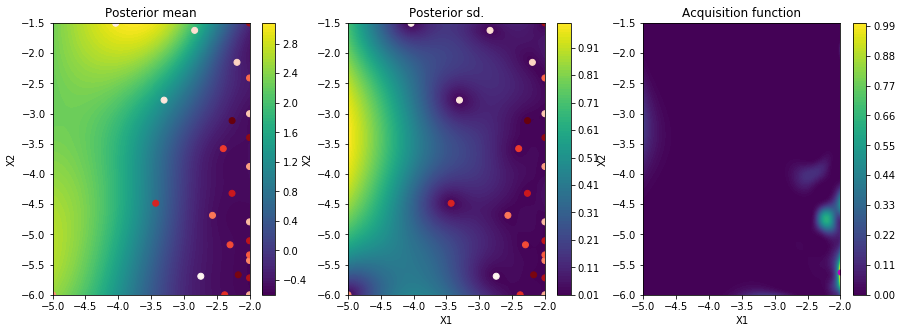

In [21]:
myBopt.plot_acquisition()

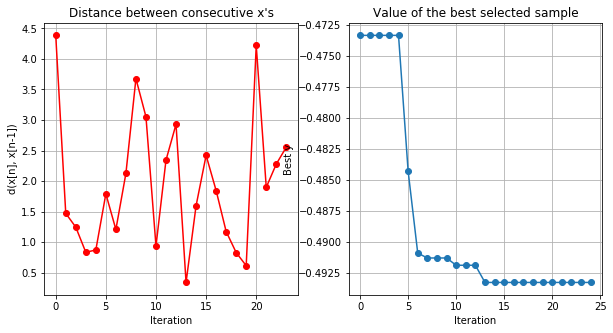

In [22]:
myBopt.plot_convergence()

In [ ]:
max_iter = 20       ## maximum number of iterations
max_time = 60       ## maximum allowed time
eps      = 1e-6     ## tolerance, max distance between consicutive evaluations.

myBopt.run_optimization(max_iter,eps=0)

## Apply Bayes Optimization to Real problem

In [3]:
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample
import torch
import torch.optim as optim
import torch.nn.functional as F
from hessian_eigenthings.power_iter import Operator, deflated_power_iteration
from hessian_eigenthings.lanczos import lanczos
from lanczos_generalized import lanczos_generalized
from GAN_hvp_operator import GANHVPOperator, GANForwardHVPOperator, compute_hessian_eigenthings
from FeatLinModel import FeatLinModel, get_model_layers
#%
import numpy as np
import matplotlib.pylab as plt
from time import time
from os.path import join
from imageio import imwrite
#from build_montages import build_montages, color_framed_montages
import torchvision.models as tv

In [4]:
BGAN = BigGAN.from_pretrained("biggan-deep-256")
for param in BGAN.parameters():
    param.requires_grad_(False)
embed_mat = BGAN.embeddings.parameters().__next__().data
BGAN.cuda()

alexnet = tv.alexnet(pretrained=True).cuda()
alexnet.eval() # this is important or there will be trial to trial variability due to DropOut
for param in alexnet.parameters():
    param.requires_grad_(False)

In [5]:
from torchvision.transforms import Normalize, Compose
RGB_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1).cuda()
RGB_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1).cuda()
preprocess = Compose([lambda img: (F.interpolate(img, (224, 224), mode='bilinear', align_corners=True) - RGB_mean) / RGB_std])
preprocess_resize = Compose([lambda img: F.interpolate(img, (224, 224), mode='bilinear', align_corners=True) ])

In [6]:
import torch.nn as nn
class BigGAN_wrapper():#nn.Module
    def __init__(self, BigGAN, space="class"):
        self.BigGAN = BigGAN
        self.space = space

    def visualize(self, code, scale=1.0):
        imgs = self.BigGAN.generator(code, 0.6)
        return torch.clamp((imgs + 1.0) / 2.0, 0, 1) * scale

G = BigGAN_wrapper(BGAN)

In [9]:
unit_id = 12
objective = FeatLinModel(alexnet, layername='classifier_1', type="neuron", chan=unit_id, pos=(1, 1))

['classifier_1']


In [29]:
def BigGAN_optim_result(param):
    lr_cls = 10**param[0, 0] # 1.5E-3
    wd_cls = 10**param[0, 1]
    lr_ns = 10**param[0, 2]
    wd_ns = 10**param[0, 3]
    success=False
    trial = 0
    MAXTRY = 100
    while not success: #  or trial < MAXTRY
        rndclassvec = torch.randn(1, 128).cuda() / np.sqrt(128) * 0.33
#         rndclassvec = embed_mat[:, np.random.randint(1000)].unsqueeze(0).clone().cuda()
        noisevec = torch.from_numpy(truncated_noise_sample(batch_size=1, dim_z=128, truncation=0.6)).cuda()
    #     ref_vect = torch.cat((noisevec, rndclassvec), dim=1).detach().clone()
        rndclassvec.requires_grad_(True)
        noisevec.requires_grad_(True)
#         print(rndclassvec.norm().item(), " ", noisevec.norm().item())
        optimizer_cls = optim.Adam([rndclassvec], lr=lr_cls, weight_decay=wd_cls) 
        optimizer_noise = optim.Adam([noisevec], lr=lr_ns, weight_decay=wd_ns)

        for step in range(200):
            optimizer_cls.zero_grad()
            img = G.visualize(torch.cat((noisevec, rndclassvec), dim=1)) # ref_vect)
            obj = objective(preprocess(img))
            obj.backward()
            optimizer_cls.step()
            optimizer_noise.step()
            if noisevec.grad.norm() < 1E-6 and rndclassvec.grad.norm() < 1E-6:
                print("No gradient, Restart optimizer from another spot.")
                trial += 1
                break
            else:
                success = True
            if np.mod((step + 1), 20) == 0:
                print("step %d: %.2f  Norm: Noise %.1f Class %.3f"%(step, obj.item(), 
                        noisevec.norm().item(), rndclassvec.norm().item()))
                print("Grad Amp Ratio Class %.2E, Noise %.2E"% 
                ((rndclassvec.grad.abs() / rndclassvec.abs()).median().item(), (noisevec.grad.abs() / noisevec.abs()).median().item()))
        if trial > MAXTRY:
            break
    if not success: 
        print("Optimization failed too many times, have a rest! ")
        return np.nan
    else:
        return obj.detach().cpu().item()

# with torch.no_grad():
#     img = G.visualize(torch.cat((noisevec, rndclassvec), dim=1))
#     act = objective(preprocess(img))
# plt.imshow(img.detach().cpu().permute(2,3,1,0).squeeze())
# plt.axis('off')
# plt.show()

In [13]:
%%time
BigGAN_optim_result(np.array([[-3.0,-4,-3,-4]]))

step 19: -5.03  Norm: Noise 5.9 Class 0.716
Grad Amp Ratio Class 8.28E+02, Noise 9.09E+01
step 39: -6.16  Norm: Noise 5.9 Class 0.727
Grad Amp Ratio Class 4.98E+02, Noise 8.45E+01
step 59: -9.48  Norm: Noise 5.9 Class 0.725
Grad Amp Ratio Class 1.18E+03, Noise 1.91E+02
step 79: -7.29  Norm: Noise 6.0 Class 0.726
Grad Amp Ratio Class 7.81E+02, Noise 1.33E+02
step 99: -12.05  Norm: Noise 6.0 Class 0.723
Grad Amp Ratio Class 5.16E+02, Noise 1.14E+02
step 119: -12.34  Norm: Noise 6.0 Class 0.725
Grad Amp Ratio Class 1.17E+03, Noise 1.71E+02
step 139: -14.01  Norm: Noise 6.0 Class 0.732
Grad Amp Ratio Class 4.32E+02, Noise 1.93E+02
step 159: -13.62  Norm: Noise 6.0 Class 0.724
Grad Amp Ratio Class 4.17E+02, Noise 1.82E+02
step 179: -15.41  Norm: Noise 6.0 Class 0.731
Grad Amp Ratio Class 8.94E+02, Noise 1.64E+02
step 199: -15.51  Norm: Noise 6.1 Class 0.726
Grad Amp Ratio Class 1.00E+03, Noise 1.87E+02
Wall time: 42.6 s


-15.508764266967773

In [30]:
%%time
BigGAN_optim_result(myBopt.x_opt[np.newaxis,:])

step 19: -6.82  Norm: Noise 6.3 Class 0.342
Grad Amp Ratio Class 1.72E+03, Noise 5.04E+01
step 39: -10.06  Norm: Noise 6.3 Class 0.359
Grad Amp Ratio Class 1.02E+03, Noise 9.69E+01
step 59: -9.60  Norm: Noise 6.3 Class 0.370
Grad Amp Ratio Class 1.29E+03, Noise 9.76E+01
step 79: -10.50  Norm: Noise 6.3 Class 0.370
Grad Amp Ratio Class 2.47E+03, Noise 2.45E+02
step 99: -10.34  Norm: Noise 6.3 Class 0.378
Grad Amp Ratio Class 3.19E+03, Noise 2.59E+02
step 119: -10.80  Norm: Noise 6.3 Class 0.377
Grad Amp Ratio Class 1.30E+03, Noise 2.12E+02
step 139: -10.43  Norm: Noise 6.3 Class 0.384
Grad Amp Ratio Class 3.07E+03, Noise 2.28E+02
step 159: -10.26  Norm: Noise 6.3 Class 0.394
Grad Amp Ratio Class 6.85E+02, Noise 1.88E+02
step 179: -10.92  Norm: Noise 6.4 Class 0.403
Grad Amp Ratio Class 9.42E+02, Noise 1.88E+02
step 199: -11.71  Norm: Noise 6.4 Class 0.413
Grad Amp Ratio Class 5.18E+02, Noise 2.06E+02
Wall time: 42.7 s


-11.713273048400879

In [14]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [16]:
%%time
mixed_domain =[{'name': 'lr_class', 'type': 'continuous', 'domain': (-4, -1.5),'dimensionality': 1},
               {'name': 'wd_class', 'type': 'continuous', 'domain': (-6, -2),'dimensionality': 1},
               {'name': 'lr_noise', 'type': 'continuous', 'domain': (-4, -1.5),'dimensionality': 1},
               {'name': 'wd_noise', 'type': 'continuous', 'domain': (-6, -2),'dimensionality': 1},]
#                {'name': 'var3', 'type': 'discrete', 'domain': (3,8,10),'dimensionality': 1},]
#                {'name': 'var4', 'type': 'categorical', 'domain': (0,1,2),'dimensionality': 1},
#                {'name': 'var5', 'type': 'continuous', 'domain': (-1,2),'dimensionality': 1}]
myBopt = BayesianOptimization(f=BigGAN_optim_result,                     # Objective function       
                             domain=mixed_domain,          # Box-constraints of the problem
                             initial_design_numdata = 5,   # Number data initial design
                             acquisition_optimizer_type='lbfgs',
                             acquisition_type='EI',        # Expected Improvement
                             exact_feval = False,         # True evaluations, no sample noise
                             verbosity = True,
                             maximize=False)           

step 19: -0.00  Norm: Noise 3.4 Class 0.653
Grad Amp Ratio Class 1.42E-03, Noise 3.75E-03
step 39: -0.00  Norm: Noise 2.4 Class 0.554
Grad Amp Ratio Class 1.42E-03, Noise 3.13E-03
step 59: -0.00  Norm: Noise 3.6 Class 0.473
Grad Amp Ratio Class 1.42E-03, Noise 2.33E-03
step 79: -0.00  Norm: Noise 4.9 Class 0.406
Grad Amp Ratio Class 1.42E-03, Noise 2.18E-03
step 99: -0.00  Norm: Noise 5.7 Class 0.349
Grad Amp Ratio Class 1.43E-03, Noise 2.03E-03
step 119: -0.00  Norm: Noise 5.6 Class 0.302
Grad Amp Ratio Class 1.43E-03, Noise 4.07E-03
step 139: -0.00  Norm: Noise 7.4 Class 0.281
Grad Amp Ratio Class 1.35E-03, Noise 4.78E+01
step 159: -0.00  Norm: Noise 14.0 Class 0.285
Grad Amp Ratio Class 1.39E-03, Noise 2.16E+01
step 179: -0.00  Norm: Noise 20.4 Class 0.286
Grad Amp Ratio Class 1.39E-03, Noise 1.24E+01
step 199: -0.00  Norm: Noise 26.3 Class 0.286
Grad Amp Ratio Class 1.39E-03, Noise 9.58E+00
step 19: -0.00  Norm: Noise 6.2 Class 0.720
Grad Amp Ratio Class 1.46E-03, Noise 1.14E+01
st

In [18]:
%%time
max_iter = 100       ## maximum number of iterations
max_time = 4000      ## maximum allowed time
eps      = 1e-6     ## tolerance, max distance between consicutive evaluations.
myBopt.run_optimization(max_iter,eps=0,verbosity = True)

step 19: -5.72  Norm: Noise 6.3 Class 0.649
Grad Amp Ratio Class 3.63E+02, Noise 3.13E+01
step 39: -8.02  Norm: Noise 6.3 Class 0.667
Grad Amp Ratio Class 6.06E+02, Noise 5.69E+01
step 59: -12.78  Norm: Noise 6.3 Class 0.682
Grad Amp Ratio Class 1.66E+03, Noise 7.32E+01
step 79: -13.33  Norm: Noise 6.3 Class 0.668
Grad Amp Ratio Class 5.34E+02, Noise 1.16E+02
step 99: -10.81  Norm: Noise 6.3 Class 0.689
Grad Amp Ratio Class 4.75E+02, Noise 1.66E+02
step 119: -10.08  Norm: Noise 6.3 Class 0.744
Grad Amp Ratio Class 3.11E+02, Noise 1.87E+02
step 139: -9.01  Norm: Noise 6.3 Class 0.780
Grad Amp Ratio Class 3.04E+02, Noise 2.00E+02
step 159: -12.87  Norm: Noise 6.3 Class 0.792
Grad Amp Ratio Class 6.11E+02, Noise 1.57E+02
step 179: -8.93  Norm: Noise 6.3 Class 0.831
Grad Amp Ratio Class 5.45E+02, Noise 1.61E+02
step 199: -13.01  Norm: Noise 6.3 Class 0.857
Grad Amp Ratio Class 3.63E+02, Noise 1.32E+02
num acquisition: 1, time elapsed: 43.74s
step 19: -0.00  Norm: Noise 5.7 Class 0.363
Grad

Grad Amp Ratio Class 1.02E-06, Noise 2.81E+01
step 159: -0.00  Norm: Noise 6.4 Class 1.504
Grad Amp Ratio Class 1.02E-06, Noise 2.80E+01
step 179: -0.00  Norm: Noise 6.4 Class 1.504
Grad Amp Ratio Class 1.02E-06, Noise 2.78E+01
step 199: -0.00  Norm: Noise 6.4 Class 1.504
Grad Amp Ratio Class 1.02E-06, Noise 2.78E+01
num acquisition: 9, time elapsed: 388.61s
step 19: -0.00  Norm: Noise 5.8 Class 0.287
Grad Amp Ratio Class 1.16E-06, Noise 4.34E-03
step 39: -0.00  Norm: Noise 5.7 Class 0.105
Grad Amp Ratio Class 1.14E-06, Noise 8.77E-03
step 59: -7.67  Norm: Noise 5.7 Class 0.130
Grad Amp Ratio Class 5.46E+03, Noise 7.24E+01
step 79: -10.86  Norm: Noise 5.7 Class 0.286
Grad Amp Ratio Class 7.62E+02, Noise 8.80E+01
step 99: -16.12  Norm: Noise 5.7 Class 0.310
Grad Amp Ratio Class 1.36E+03, Noise 6.21E+01
step 119: -18.42  Norm: Noise 5.7 Class 0.348
Grad Amp Ratio Class 6.54E+02, Noise 1.18E+02
step 139: -20.20  Norm: Noise 5.7 Class 0.386
Grad Amp Ratio Class 6.55E+02, Noise 1.58E+02
ste

Grad Amp Ratio Class 1.97E-06, Noise 2.05E+01
step 79: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.08E+01
step 99: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.09E+01
step 119: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.11E+01
step 139: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.10E+01
step 159: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.11E+01
step 179: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.13E+01
step 199: -0.00  Norm: Noise 6.4 Class 0.553
Grad Amp Ratio Class 1.97E-06, Noise 2.16E+01
num acquisition: 18, time elapsed: 776.41s
step 19: -2.31  Norm: Noise 5.8 Class 0.569
Grad Amp Ratio Class 1.09E+03, Noise 6.63E+01
step 39: -15.88  Norm: Noise 5.8 Class 0.585
Grad Amp Ratio Class 1.18E+03, Noise 1.10E+02
step 59: -18.69  Norm: Noise 5.8 Class 0.578
Grad Amp Ratio Class 1.88E+03, Noise 8.79E+01
step

Grad Amp Ratio Class 9.72E+02, Noise 2.05E+02
step 199: -22.65  Norm: Noise 5.9 Class 0.991
Grad Amp Ratio Class 4.97E+02, Noise 1.98E+02
num acquisition: 26, time elapsed: 1120.70s
step 19: -9.72  Norm: Noise 6.5 Class 0.653
Grad Amp Ratio Class 5.64E+02, Noise 4.96E+01
step 39: -13.18  Norm: Noise 6.5 Class 0.674
Grad Amp Ratio Class 3.86E+02, Noise 1.19E+02
step 59: -14.88  Norm: Noise 6.5 Class 0.688
Grad Amp Ratio Class 3.69E+02, Noise 8.64E+01
step 79: -15.55  Norm: Noise 6.5 Class 0.698
Grad Amp Ratio Class 1.13E+03, Noise 8.47E+01
step 99: -17.51  Norm: Noise 6.5 Class 0.711
Grad Amp Ratio Class 5.49E+02, Noise 8.17E+01
step 119: -19.05  Norm: Noise 6.6 Class 0.720
Grad Amp Ratio Class 3.00E+02, Noise 7.93E+01
step 139: -18.78  Norm: Noise 6.6 Class 0.723
Grad Amp Ratio Class 4.72E+02, Noise 9.70E+01
step 159: -19.52  Norm: Noise 6.6 Class 0.731
Grad Amp Ratio Class 4.31E+02, Noise 9.89E+01
step 179: -20.04  Norm: Noise 6.6 Class 0.733
Grad Amp Ratio Class 5.37E+02, Noise 1.10E

step 99: -5.99  Norm: Noise 5.2 Class 0.521
Grad Amp Ratio Class 9.42E+02, Noise 1.23E+02
step 119: -6.87  Norm: Noise 5.2 Class 0.520
Grad Amp Ratio Class 5.57E+02, Noise 9.85E+01
step 139: -7.81  Norm: Noise 5.2 Class 0.531
Grad Amp Ratio Class 1.78E+03, Noise 1.49E+02
step 159: -8.92  Norm: Noise 5.3 Class 0.533
Grad Amp Ratio Class 1.11E+03, Noise 1.64E+02
step 179: -9.13  Norm: Noise 5.3 Class 0.520
Grad Amp Ratio Class 1.02E+03, Noise 1.68E+02
step 199: -8.68  Norm: Noise 5.3 Class 0.528
Grad Amp Ratio Class 4.61E+02, Noise 1.74E+02
num acquisition: 35, time elapsed: 1508.88s
step 19: -4.73  Norm: Noise 6.4 Class 0.383
Grad Amp Ratio Class 1.37E+03, Noise 1.79E+01
step 39: -2.65  Norm: Noise 6.4 Class 0.398
Grad Amp Ratio Class 1.65E+03, Noise 2.46E+01
step 59: -0.00  Norm: Noise 6.4 Class 0.401
Grad Amp Ratio Class 1.46E-06, Noise 8.21E+01
step 79: -0.00  Norm: Noise 6.4 Class 0.408
Grad Amp Ratio Class 1.47E-06, Noise 7.44E+01
step 99: -0.00  Norm: Noise 6.4 Class 0.408
Grad Am

num acquisition: 43, time elapsed: 1853.69s
step 19: -4.30  Norm: Noise 5.8 Class 0.653
Grad Amp Ratio Class 4.64E+02, Noise 3.17E+01
step 39: -2.39  Norm: Noise 5.8 Class 0.636
Grad Amp Ratio Class 8.94E+02, Noise 7.21E+01
step 59: -6.91  Norm: Noise 5.8 Class 0.646
Grad Amp Ratio Class 3.09E+02, Noise 5.67E+01
step 79: -7.07  Norm: Noise 5.8 Class 0.624
Grad Amp Ratio Class 1.34E+03, Noise 1.24E+02
step 99: -4.44  Norm: Noise 5.8 Class 0.645
Grad Amp Ratio Class 1.51E+03, Noise 1.14E+02
step 119: -4.86  Norm: Noise 5.8 Class 0.646
Grad Amp Ratio Class 4.40E+02, Noise 9.19E+01
step 139: -3.97  Norm: Noise 5.9 Class 0.662
Grad Amp Ratio Class 3.97E+02, Noise 1.23E+02
step 159: -3.81  Norm: Noise 5.9 Class 0.661
Grad Amp Ratio Class 9.58E+02, Noise 1.30E+02
step 179: -2.99  Norm: Noise 5.9 Class 0.678
Grad Amp Ratio Class 2.06E+03, Noise 1.21E+02
step 199: -2.24  Norm: Noise 5.9 Class 0.715
Grad Amp Ratio Class 9.80E+02, Noise 1.64E+02
num acquisition: 44, time elapsed: 1896.55s
step 19

step 139: -9.66  Norm: Noise 6.1 Class 0.714
Grad Amp Ratio Class 4.80E+02, Noise 1.16E+02
step 159: -10.70  Norm: Noise 6.1 Class 0.733
Grad Amp Ratio Class 5.10E+02, Noise 1.51E+02
step 179: -10.10  Norm: Noise 6.1 Class 0.722
Grad Amp Ratio Class 4.97E+02, Noise 1.70E+02
step 199: -17.75  Norm: Noise 6.1 Class 0.745
Grad Amp Ratio Class 7.72E+02, Noise 1.22E+02
num acquisition: 52, time elapsed: 2241.47s
step 19: -0.00  Norm: Noise 5.9 Class 0.346
Grad Amp Ratio Class 1.09E-06, Noise 5.55E+01
step 39: -0.00  Norm: Noise 5.9 Class 0.444
Grad Amp Ratio Class 1.17E-06, Noise 5.50E+01
step 59: -0.00  Norm: Noise 5.9 Class 0.461
Grad Amp Ratio Class 1.17E-06, Noise 5.43E+01
step 79: -0.00  Norm: Noise 5.9 Class 0.463
Grad Amp Ratio Class 1.17E-06, Noise 5.32E+01
step 99: -1.91  Norm: Noise 5.9 Class 0.599
Grad Amp Ratio Class 3.28E+02, Noise 4.98E+01
step 119: -3.71  Norm: Noise 5.9 Class 0.755
Grad Amp Ratio Class 2.99E+02, Noise 3.56E+01
step 139: -2.72  Norm: Noise 5.9 Class 0.794
Gra

Grad Amp Ratio Class 4.88E+02, Noise 1.85E+01
step 59: -12.16  Norm: Noise 10.1 Class 1.317
Grad Amp Ratio Class 2.93E+02, Noise 2.17E+01
step 79: -18.19  Norm: Noise 12.9 Class 1.345
Grad Amp Ratio Class 2.06E+02, Noise 1.61E+01
step 99: -22.34  Norm: Noise 15.7 Class 1.380
Grad Amp Ratio Class 3.79E+02, Noise 1.42E+01
step 119: -27.14  Norm: Noise 18.7 Class 1.465
Grad Amp Ratio Class 2.10E+02, Noise 1.22E+01
step 139: -23.44  Norm: Noise 22.2 Class 1.532
Grad Amp Ratio Class 1.66E+02, Noise 1.14E+01
step 159: -19.85  Norm: Noise 26.0 Class 1.605
Grad Amp Ratio Class 3.31E+02, Noise 1.02E+01
step 179: -24.72  Norm: Noise 29.4 Class 1.669
Grad Amp Ratio Class 3.66E+02, Noise 8.61E+00
step 199: -21.43  Norm: Noise 32.9 Class 1.679
Grad Amp Ratio Class 1.82E+02, Noise 7.08E+00
num acquisition: 61, time elapsed: 2629.09s
step 19: -0.00  Norm: Noise 6.1 Class 0.512
Grad Amp Ratio Class 5.22E-04, Noise 3.58E+01
step 39: -0.00  Norm: Noise 6.1 Class 0.526
Grad Amp Ratio Class 5.24E-04, Nois

Grad Amp Ratio Class 1.12E-06, Noise 1.72E+01
step 179: -0.00  Norm: Noise 5.4 Class 0.590
Grad Amp Ratio Class 1.12E-06, Noise 1.69E+01
step 199: -0.00  Norm: Noise 5.4 Class 0.590
Grad Amp Ratio Class 1.12E-06, Noise 1.65E+01
num acquisition: 69, time elapsed: 2973.51s
step 19: -0.00  Norm: Noise 6.0 Class 0.255
Grad Amp Ratio Class 1.82E-06, Noise 6.48E-03
step 39: -9.19  Norm: Noise 6.0 Class 0.220
Grad Amp Ratio Class 6.20E+03, Noise 7.86E+01
step 59: -6.46  Norm: Noise 6.0 Class 0.255
Grad Amp Ratio Class 1.47E+03, Noise 1.01E+02
step 79: -8.90  Norm: Noise 6.0 Class 0.272
Grad Amp Ratio Class 2.37E+03, Noise 1.32E+02
step 99: -13.52  Norm: Noise 6.0 Class 0.300
Grad Amp Ratio Class 2.36E+03, Noise 1.98E+02
step 119: -11.84  Norm: Noise 6.0 Class 0.306
Grad Amp Ratio Class 4.28E+03, Noise 1.82E+02
step 139: -16.85  Norm: Noise 6.0 Class 0.306
Grad Amp Ratio Class 5.71E+03, Noise 1.92E+02
step 159: -17.68  Norm: Noise 6.0 Class 0.313
Grad Amp Ratio Class 2.57E+03, Noise 2.02E+02
s

step 79: -0.00  Norm: Noise 5.8 Class 0.207
Grad Amp Ratio Class 1.11E-06, Noise 5.13E+01
step 99: -0.00  Norm: Noise 5.8 Class 0.225
Grad Amp Ratio Class 1.12E-06, Noise 4.78E+01
step 119: -6.44  Norm: Noise 5.8 Class 0.321
Grad Amp Ratio Class 1.67E+03, Noise 1.38E+02
step 139: -7.74  Norm: Noise 5.8 Class 0.377
Grad Amp Ratio Class 1.32E+03, Noise 7.72E+01
step 159: -9.93  Norm: Noise 5.8 Class 0.371
Grad Amp Ratio Class 8.23E+02, Noise 1.28E+02
step 179: -10.48  Norm: Noise 5.8 Class 0.389
Grad Amp Ratio Class 8.15E+02, Noise 8.63E+01
step 199: -10.50  Norm: Noise 5.8 Class 0.397
Grad Amp Ratio Class 4.40E+02, Noise 1.71E+02
num acquisition: 78, time elapsed: 3362.91s
step 19: -0.00  Norm: Noise 5.7 Class 0.273
Grad Amp Ratio Class 1.19E-06, Noise 4.02E-03
step 39: -0.00  Norm: Noise 5.7 Class 0.153
Grad Amp Ratio Class 1.06E-06, Noise 9.74E+01
step 59: -5.74  Norm: Noise 5.7 Class 0.220
Grad Amp Ratio Class 4.49E+03, Noise 7.93E+01
step 79: -5.87  Norm: Noise 5.7 Class 0.245
Grad 

step 199: -0.00  Norm: Noise 6.2 Class 0.450
Grad Amp Ratio Class 1.12E-06, Noise 5.15E+01
num acquisition: 86, time elapsed: 3708.30s
step 19: -0.00  Norm: Noise 6.3 Class 0.347
Grad Amp Ratio Class 1.18E-06, Noise 4.02E-03
step 39: -0.00  Norm: Noise 6.2 Class 0.188
Grad Amp Ratio Class 1.20E-06, Noise 8.10E-03
step 59: -0.00  Norm: Noise 6.1 Class 0.108
Grad Amp Ratio Class 1.18E-06, Noise 1.23E-02
step 79: -0.00  Norm: Noise 6.0 Class 0.063
Grad Amp Ratio Class 1.16E-06, Noise 1.66E-02
step 99: -0.00  Norm: Noise 6.0 Class 0.035
Grad Amp Ratio Class 1.18E-06, Noise 2.10E-02
step 119: -0.00  Norm: Noise 5.9 Class 0.018
Grad Amp Ratio Class 1.20E-06, Noise 2.55E-02
step 139: -0.00  Norm: Noise 5.8 Class 0.009
Grad Amp Ratio Class 1.17E-06, Noise 2.98E-02
step 159: -0.00  Norm: Noise 5.7 Class 0.004
Grad Amp Ratio Class 1.21E-06, Noise 3.44E-02
step 179: -0.00  Norm: Noise 5.7 Class 0.002
Grad Amp Ratio Class 1.18E-06, Noise 3.91E-02
step 199: -0.00  Norm: Noise 5.6 Class 0.001
Grad A

Grad Amp Ratio Class 3.43E+02, Noise 1.02E+02
step 119: -15.41  Norm: Noise 5.9 Class 0.705
Grad Amp Ratio Class 3.72E+02, Noise 1.09E+02
step 139: -17.03  Norm: Noise 5.9 Class 0.705
Grad Amp Ratio Class 4.77E+02, Noise 1.15E+02
step 159: -18.33  Norm: Noise 5.9 Class 0.710
Grad Amp Ratio Class 4.59E+02, Noise 1.35E+02
step 179: -19.39  Norm: Noise 5.9 Class 0.712
Grad Amp Ratio Class 5.88E+02, Noise 1.47E+02
step 199: -20.41  Norm: Noise 5.9 Class 0.713
Grad Amp Ratio Class 4.07E+02, Noise 1.38E+02
num acquisition: 95, time elapsed: 4098.04s
step 19: -0.00  Norm: Noise 5.6 Class 0.594
Grad Amp Ratio Class 2.62E-06, Noise 9.37E+00
step 39: -0.00  Norm: Noise 5.6 Class 0.606
Grad Amp Ratio Class 2.63E-06, Noise 9.27E+00
step 59: -0.00  Norm: Noise 5.6 Class 0.608
Grad Amp Ratio Class 2.63E-06, Noise 9.20E+00
step 79: -0.00  Norm: Noise 5.6 Class 0.609
Grad Amp Ratio Class 2.63E-06, Noise 9.10E+00
step 99: -0.00  Norm: Noise 5.6 Class 0.609
Grad Amp Ratio Class 2.63E-06, Noise 8.98E+00


In [19]:
myBopt.fx_opt

-30.32238006591797

In [28]:
%%time
BigGAN_optim_result(myBopt.x_opt[np.newaxis,:])

step 19: -0.70  Norm: Noise 5.5 Class 0.763
Grad Amp Ratio Class 3.48E+02, Noise 3.53E+01
step 39: -5.64  Norm: Noise 5.5 Class 0.783
Grad Amp Ratio Class 1.72E+02, Noise 4.64E+01
step 59: -7.49  Norm: Noise 5.5 Class 0.774
Grad Amp Ratio Class 4.81E+02, Noise 4.93E+01
step 79: -8.44  Norm: Noise 5.5 Class 0.760
Grad Amp Ratio Class 1.70E+02, Noise 6.06E+01
step 99: -9.36  Norm: Noise 5.5 Class 0.754
Grad Amp Ratio Class 2.27E+02, Noise 7.56E+01
step 119: -9.60  Norm: Noise 5.5 Class 0.765
Grad Amp Ratio Class 4.08E+02, Noise 9.88E+01
step 139: -10.73  Norm: Noise 5.5 Class 0.782
Grad Amp Ratio Class 3.33E+02, Noise 9.64E+01
step 159: -11.71  Norm: Noise 5.5 Class 0.782
Grad Amp Ratio Class 5.28E+02, Noise 1.30E+02
step 179: -12.21  Norm: Noise 5.5 Class 0.782
Grad Amp Ratio Class 3.54E+02, Noise 1.18E+02
step 199: -13.01  Norm: Noise 5.5 Class 0.803
Grad Amp Ratio Class 2.38E+02, Noise 1.25E+02
Wall time: 44.2 s


-13.008824348449707

In [21]:
myBopt.Y_best

array([ -0.        ,  -0.        ,  -0.        , -15.35709476,
       -15.35709476, -15.35709476, -15.35709476, -28.21632576,
       -28.21632576, -28.21632576, -28.21632576, -28.21632576,
       -28.21632576, -28.21632576, -28.21632576, -28.21632576,
       -28.21632576, -28.21632576, -28.21632576, -28.21632576,
       -28.21632576, -28.21632576, -28.21632576, -28.21632576,
       -28.21632576, -28.21632576, -28.21632576, -28.21632576,
       -28.21632576, -28.21632576, -28.21632576, -28.21632576,
       -28.21632576, -29.37039375, -29.37039375, -29.37039375,
       -29.37039375, -29.37039375, -29.37039375, -29.37039375,
       -29.37039375, -29.37039375, -29.37039375, -29.37039375,
       -29.37039375, -29.37039375, -30.32238007, -30.32238007,
       -30.32238007, -30.32238007, -30.32238007, -30.32238007,
       -30.32238007, -30.32238007, -30.32238007, -30.32238007,
       -30.32238007, -30.32238007, -30.32238007, -30.32238007,
       -30.32238007, -30.32238007, -30.32238007, -30.32

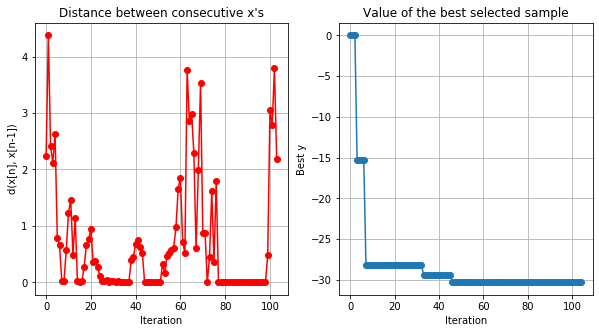

In [22]:
myBopt.plot_convergence()

In [24]:
myBopt.plot_acquisition()